# Animal Shelter Pt. 2 - Adoption Rate Prediction
- In Part 1, the dependent variable was "Outcome Type", meaning the model predicts whether an animal will face a positive (adopted, returned to owner, transfer) or negative (euthanize, dead, disposed, stolen) outcome.


- In this section, the dependent variable is "days in shelter"
    - How long will an animal stay at the shelter?
    - How can the shelter increase a given animal's appeal to increase adoption rate?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from pylab import savefig

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, make_scorer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

plt.style.use('ggplot')

#show all columns
pd.set_option('display.max_columns', None)

In [2]:
#import csv into a pandas dataframe
df = pd.read_csv('Animal_Shelter_Intake_and_Outcome.csv')

In [5]:
#how much of the data are NaN's?
df.isna().sum()/len(df)

Name                    0.256197
Type                    0.000000
Breed                   0.000000
Color                   0.000000
Sex                     0.000000
Size                    0.001552
Date Of Birth           0.241324
Impound Number          0.000000
Kennel Number           0.000401
Animal ID               0.000000
Intake Date             0.000000
Outcome Date            0.004407
Days in Shelter         0.000000
Intake Type             0.000000
Intake Subtype          0.000000
Outcome Type            0.004657
Outcome Subtype         0.014272
Intake Condition        0.000000
Outcome Condition       0.015674
Intake Jurisdiction     0.000000
Outcome Jurisdiction    0.139516
Outcome Zip Code        0.141069
Location                0.141069
Count                   0.000000
Intake_Month            0.000000
Intake_dayofweek        0.000000
Intake_Year             0.000000
Outcome_Month           0.004407
Outcome_dayofweek       0.004407
Outcome_Year            0.004407
dtype: flo

In [6]:
#datetime_type = year, month, dayofweek, or hour
def parse_date_cols(df, col: str, new_col: str, datetime_type: str):
    df[col] = pd.to_datetime(df[col])
    if datetime_type == 'year':
        df[new_col] = df[col].dt.year
    elif datetime_type == 'month':
        df[new_col] = df[col].dt.month
    elif datetime_type == 'dayofweek':
        df[new_col] = df[col].dt.dayofweek
    elif datetime_type == 'hour':
        df[new_col] = df[col].dt.hour
    else:
        print("wrong datetime type")
    return df

#convert col values dtype: int, float, string, etc
def convert_dtype(df, col: str, new_dtype: str):
    df[col] = df[col].astype(new_dtype)
    return df

#convert dtype in columns
parse_date_cols(df, 'Outcome Date', '_', '_')
parse_date_cols(df, 'Date Of Birth', '_', '_')
convert_dtype(df, 'Days in Shelter', 'int')

#Create month, dayofweek, year columns from intake date
parse_date_cols(df, 'Intake Date', 'Intake_Month', datetime_type='month')
parse_date_cols(df, 'Intake Date', 'Intake_dayofweek', datetime_type='dayofweek')
parse_date_cols(df, 'Intake Date', 'Intake_Year', datetime_type='year')

# Parse 'Outcome Date' for EDA, not for modeling - potential data leakage
parse_date_cols(df, 'Outcome Date', 'Outcome_Month', datetime_type='month')
parse_date_cols(df, 'Outcome Date', 'Outcome_dayofweek', datetime_type='dayofweek')
parse_date_cols(df, 'Outcome Date', 'Outcome_Year', datetime_type='year')

wrong datetime type
wrong datetime type


,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Intake_Month,Intake_dayofweek,Intake_Year,Outcome_Month,Outcome_dayofweek,Outcome_Year
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaT,K20-035118,DS69,A395686,2020-01-19,2020-01-23,4,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1,1,6,2020,1.0,3.0,2020.0
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,2015-04-06,K17-025093,DS83,A379968,2017-08-30,2017-10-04,35,STRAY,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1,8,2,2017,10.0,2.0,2017.0
2,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,2011-01-23,K15-012348,DA34,A315553,2015-01-07,2015-01-24,17,STRAY,OVER THE COUNTER,ADOPTION,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1,1,2,2015,1.0,5.0,2015.0
3,NaN,DOG,GERM SHEPHERD/MIX,TRICOLOR,Unknown,MED,NaT,K20-036188,VET,A398868,2020-07-12,2020-07-12,0,CONFISCATE,FLD_CRUEL,RETURN TO OWNER,MEDICAL,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1,7,6,2020,7.0,6.0,2020.0
4,FELIX,CAT,DOMESTIC SH,BLACK,Neutered,KITTN,2018-05-12,K18-029084,LOBBY,A374683,2018-07-12,2018-08-04,23,STRAY,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95407.0,"95407(38.403734, -122.736775)",1,7,3,2018,8.0,5.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,*ONYX,CAT,DOMESTIC SH,BLACK,Neutered,SMALL,2011-02-23,K16-017789,CS04,A333091,2016-02-13,2016-03-18,34,STRAY,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95403.0,"95403(38.486997, -122.749134)",1,2,5,2016,3.0,4.0,2016.0
19965,NaN,DOG,CHIHUAHUA SH,TAN,Female,TOY,NaT,K15-013157,DS91,A317956,2015-03-14,2015-04-23,40,STRAY,OVER THE COUNTER,EUTHANIZE,AGGRESSIVE,TREATABLE/REHAB,UNTREATABLE,SANTA ROSA,NaN,NaN,NaN,1,3,5,2015,4.0,3.0,2015.0
19966,TEDDY BEAR,DOG,BICHON FRISE/MIX,CREAM,Neutered,SMALL,2011-06-15,K18-028664,DA20,A374057,2018-06-15,2018-06-15,0,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1,6,4,2018,6.0,4.0,2018.0
19967,TIPPY,CAT,DOMESTIC SH,BLACK/WHITE,Spayed,SMALL,2009-10-13,K17-025618,CA03,A362428,2017-10-09,2017-11-05,27,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_PRVS,UNKNOWN,HEALTHY,SANTA ROSA,COUNTY,95403.0,"95403(38.486997, -122.749134)",1,10,0,2017,11.0,6.0,2017.0


In [7]:
# Create "Age" column that subtracts the pet's date of birth from the intake date
# choose method: median, mean, or 0 --> to replace NaN's
def create_fill_age_col(df, method='median'):
    df['Age'] = df['Intake Date'] - df['Date Of Birth']
    df['Age'] = df['Age'].dt.days.astype(float)
    
    if method == 'median':
        df['Age'] = df['Age'].fillna(df['Age'].median())
    
    elif method == 'mean':
        df['Age'] = df['Age'].fillna(df['Age'].mean())
    
    elif method == '0':
        df['Age'] = df['Age'].fillna(0)
        
    #convert from age in Days to Years
    df['Age'] = round(df['Age'] / 365, 2)
    
    #drop DoB col
    df = df.drop(columns='Date Of Birth', inplace=True)
        
    return df

create_fill_age_col(df)

In [8]:
def simplify_col_vals(df, col:str, value:list, replacement:list):
    # spayed --> female, neutered --> male, unknown remains as is
    df[col] = df[col].replace(value, replacement*len(value))

# Simplify 'Sex' column from 5 unique vals into 3 - Male, Female, Unknown
simplify_col_vals(df, 'Sex', ['Neutered'], ['Male'])
simplify_col_vals(df, 'Sex', ['Spayed'], ['Female'])

# Simplify 'Outcome Type' --> "good" vs"bad"? --- may need to seperate Adoption to its own class
outcome_good = ['ADOPTION', 'RETURN TO OWNER', 'RTOS', 'TRANSFER']
outcome_bad = ['DIED', 'DISPOSAL', 'EUTHANIZE', 'ESCAPED/STOLEN']

#drop 93 throws with missing 'Outcome Type'
df = df[df['Outcome Type'].notna()]
simplify_col_vals(df, 'Outcome Type', outcome_bad, [0])
simplify_col_vals(df, 'Outcome Type', outcome_good, [1])
#this ends up with 3000 "bad" (0), and 17000 "good" (1)

#simplify 'Size' column
smol = ['KITTN', 'PUPPY', 'TOY']
simplify_col_vals(df, 'Size', smol, ['SMALL'])

<ipython-input-8-00482e6c4c8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(value, replacement*len(value))


In [11]:
df_good = df[df['Outcome Type'] == 1]
df_bad = df[df['Outcome Type'] == 0]

Intake Condition
HEALTHY                 10672
TREATABLE/MANAGEABLE      888
TREATABLE/REHAB          1908
UNKNOWN                  3295
UNTREATABLE                57
Name: Animal ID, dtype: int64

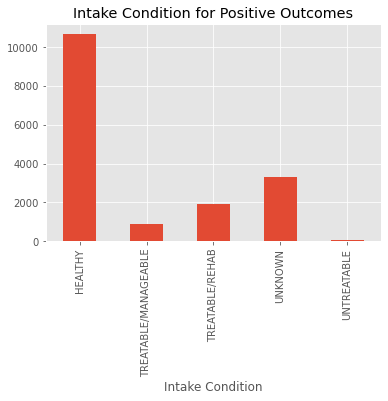

In [13]:
df_good.groupby('Intake Condition').count()['Animal ID'].plot(kind='bar', 
                                                               title="Intake Condition for Positive Outcomes")

df_good.groupby('Intake Condition').count()['Animal ID']

Outcome Condition
DEAD                       45
HEALTHY                 12937
PENDING                  1536
TREATABLE/MANAGEABLE      868
TREATABLE/REHAB          1188
UNTREATABLE                42
Name: Animal ID, dtype: int64

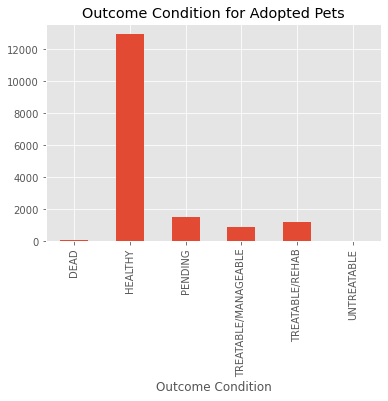

In [14]:
df_good.groupby('Outcome Condition').count()['Animal ID'].plot(kind='bar', 
                                                               title="Outcome Condition for Adopted Pets")
df_good.groupby('Outcome Condition').count()['Animal ID']

count    16820.000000
mean        17.508026
std         33.444844
min          0.000000
25%          1.000000
50%          8.000000
75%         22.000000
max        891.000000
Name: Days in Shelter, dtype: float64

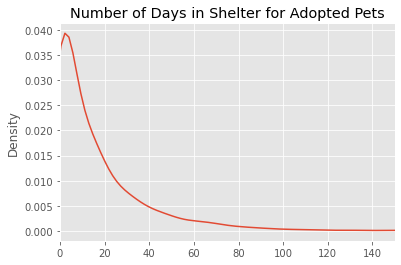

In [22]:
df_good['Days in Shelter'].plot(kind='kde', xlim=(0,150), title='Number of Days in Shelter for Adopted Pets')
df_good['Days in Shelter'].describe()

In [27]:
df_good[df_good['Days in Shelter'] > 200]

,Name,Type,Breed,Color,Sex,Size,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Intake_Month,Intake_dayofweek,Intake_Year,Outcome_Month,Outcome_dayofweek,Outcome_Year,Age
98,ARNOLD,DOG,PIT BULL,BROWN/WHITE,Male,LARGE,K15-016906,DA37,A329869,2015-11-25,2016-10-05,315,STRAY,OVER THE COUNTER,1,REFERRAL,TREATABLE/MANAGEABLE,TREATABLE/MANAGEABLE,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1,11,2,2015,10.0,2.0,2016.0,1.46
364,PEARL,DOG,DACHSHUND,BROWN/WHITE,Female,SMALL,K17-026012,DA47,A308868,2017-10-24,2020-04-02,891,CONFISCATE,FLD_CRUEL,1,ROCKET DOG,TREATABLE/MANAGEABLE,TREATABLE/MANAGEABLE,COUNTY,OUT OF COUNTY,94146.0,"94146(37.78008, -122.420168)",1,10,1,2017,4.0,3.0,2020.0,7.85
369,ZIGZAG,DOG,DACHSHUND,BROWN/WHITE,Male,SMALL,K17-026010,DA46,A308867,2017-10-24,2020-04-02,891,CONFISCATE,FLD_CRUEL,1,ROCKET DOG,TREATABLE/MANAGEABLE,TREATABLE/MANAGEABLE,COUNTY,OUT OF COUNTY,94146.0,"94146(37.78008, -122.420168)",1,10,1,2017,4.0,3.0,2020.0,9.01
561,*QUIX,DOG,CATAHOULA/MIX,BLUE MERLE/WHITE,Male,MED,K18-027244,DA35,A368065,2018-02-10,2020-04-13,793,CONFISCATE,FLD_CRUEL,1,ROCKET DOG,TREATABLE/MANAGEABLE,TREATABLE/MANAGEABLE,COUNTY,OUT OF COUNTY,94146.0,"94146(37.78008, -122.420168)",1,2,5,2018,4.0,0.0,2020.0,2.93
968,EDWINA,OTHER,DONKEY,BROWN/GRAY,Female,LARGE,K19-032550,FOSTER,A388031,2019-06-05,2020-01-13,222,STRAY,FIELD,1,VOLUNTEER,UNKNOWN,HEALTHY,COUNTY,COUNTY,95492.0,"95492(38.541541, -122.809202)",1,6,2,2019,1.0,0.0,2020.0,30.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,*PEANUT,DOG,CHIHUAHUA SH,TAN/WHITE,Female,SMALL,K17-025858,RECEIVING,A362645,2017-10-16,2018-05-18,214,STRAY,OVER THE COUNTER,1,REFERRAL-V,TREATABLE/REHAB,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,"95409(38.458965, -122.630156)",1,10,0,2017,5.0,4.0,2018.0,0.83
19007,*DRAKE,DOG,PIT BULL,RED,Male,MED,K14-010666,RECEIVING,A311330,2014-09-07,2015-05-22,257,STRAY,FIELD,1,INTERNET,HEALTHY,HEALTHY,COUNTY,COUNTY,94952.0,"94952(38.236012, -122.730241)",1,9,6,2014,5.0,4.0,2015.0,2.92
19136,*BRODY,DOG,PIT BULL,GRAY,Male,LARGE,K15-016311,DA31,A328080,2015-10-08,2016-05-27,232,STRAY,FIELD,1,FACEBOOK,HEALTHY,HEALTHY,SANTA ROSA,OUT OF COUNTY,94533.0,"94533(38.27114, -122.026467)",1,10,3,2015,5.0,4.0,2016.0,1.94
19230,SASSY,DOG,PIT BULL/MIX,BLACK/WHITE,Female,LARGE,K18-029302,DA02,A375078,2018-07-31,2019-03-21,233,TRANSFER,PRIV_SHELT,1,WALKIN,TREATABLE/MANAGEABLE,TREATABLE/MANAGEABLE,OUT OF COUNTY,*ROHNERT PARK,94928.0,"94928(38.346718, -122.695947)",1,7,1,2018,3.0,3.0,2019.0,4.41


count    3056.000000
mean       14.925065
std        28.807072
min         0.000000
25%         0.000000
50%         8.000000
75%        18.000000
max       798.000000
Name: Days in Shelter, dtype: float64

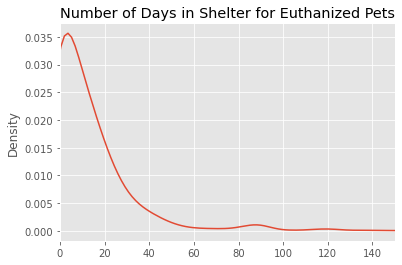

In [23]:
df_bad['Days in Shelter'].plot(kind='kde', xlim=(0,150), title='Number of Days in Shelter for Euthanized Pets')

df_bad['Days in Shelter'].describe()

Intake Condition
HEALTHY                  230
TREATABLE/MANAGEABLE     340
TREATABLE/REHAB          140
UNKNOWN                  478
UNTREATABLE             1868
Name: Animal ID, dtype: int64

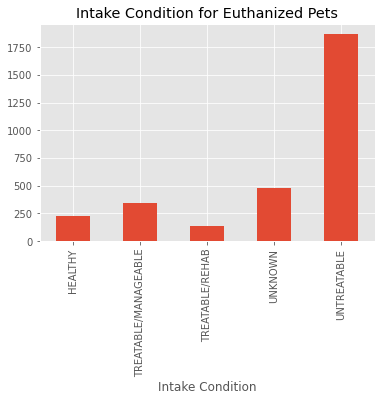

In [17]:
df_bad.groupby('Intake Condition').count()['Animal ID'].plot(kind='bar', 
                                                                 title="Intake Condition for Euthanized Pets")
df_bad.groupby('Intake Condition').count()['Animal ID']

Outcome Condition
DEAD                     264
HEALTHY                   19
PENDING                    7
TREATABLE/MANAGEABLE     380
TREATABLE/REHAB           29
UNTREATABLE             2341
Name: Animal ID, dtype: int64

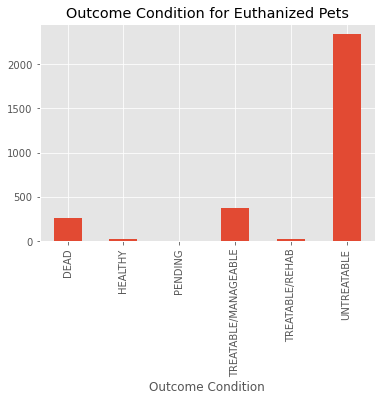

In [18]:
df_bad.groupby('Outcome Condition').count()['Animal ID'].plot(kind='bar', 
                                                                 title="Outcome Condition for Euthanized Pets")

df_bad.groupby('Outcome Condition').count()['Animal ID']

## For our classifier, it might be best to break the `Outcome Type` into 2 groups:
    # Good(adopted, returned, transfer) vs Bad(euthanize, disposal, died, escaped/stolen)
    
### Good and Bad outcomes will be the dependent variable (y), but it will also be heavily imbalanced
    #About 16,700 animals fall in "Good", and About 3,000 fall in "Bad" --- 85% good, 15% bad
    # Do SMOTE on the "Bad" class..?

In [20]:
df['Outcome Type'].unique()
# 0 is "bad", 1 is "good"
# Not sure whether to isolate "Adopted" to its own class -- about 6.3k

array([1, 0])

Outcome Type
ADOPTION           6326
DIED                135
DISPOSAL            125
ESCAPED/STOLEN       17
EUTHANIZE          2779
RETURN TO OWNER    6711
RTOS                 11
TRANSFER           3772
Name: Animal ID, dtype: int64

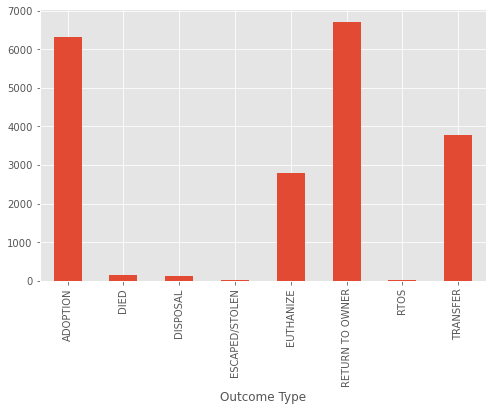

In [14]:
df.groupby('Outcome Type').count()['Animal ID'].plot(kind='bar', figsize=(8,5))
df.groupby('Outcome Type').count()['Animal ID']

In [15]:
def show_unique_vals(df, col):
    return df[col].unique()

def show_groupby_count(df, col):
    return df.groupby(col).count()

In [16]:
def sort_ascending(df, column: str, asc=True):
    df = df.sort_values(column, ascending=asc)
    return df

#sort df by Intake Date so it's in chronological order
sort_ascending(df, 'Intake Date')

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Intake_Month,Intake_dayofweek,Intake_Year,Outcome_Month,Outcome_dayofweek,Outcome_Year
9485,ATHENA,OTHER,RABBIT SH,BLACK,Spayed,SMALL,2010-08-16,K13-005008,SMA,A295655,2013-08-16,2014-01-04,141,STRAY,OVER THE COUNTER,ADOPTION,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95472.0,"95472(38.394388, -122.850998)",1,8,4,2013,1.0,5.0,2014.0
10304,ZIGGY,CAT,DOMESTIC SH,ORG TABBY/WHITE,Spayed,SMALL,2007-08-28,K13-005041,WESTFARM,A295782,2013-08-17,2014-01-07,143,STRAY,OVER THE COUNTER,ADOPTION,WESTFARM,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95472.0,"95472(38.394388, -122.850998)",1,8,5,2013,1.0,1.0,2014.0
6320,*ALICE,DOG,PIT BULL,GRAY/WHITE,Spayed,MED,2012-09-03,K13-005161,DA38,A296009,2013-08-22,2014-04-14,235,TRANSFER,VET_HOSP,EUTHANIZE,BEH SEVERE,HEALTHY,UNTREATABLE,COUNTY,NaN,NaN,NaN,1,8,3,2013,4.0,0.0,2014.0
12819,NALA,CAT,DOMESTIC SH,CALICO,Spayed,SMALL,2007-03-27,K13-005202,LOBBY,A296108,2013-08-24,2014-03-01,189,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,WALKIN,TREATABLE/REHAB,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,"95409(38.458965, -122.630156)",1,8,5,2013,3.0,5.0,2014.0
12122,KHLOE,DOG,PIT BULL,BLUE/WHITE,Spayed,MED,2012-10-09,K13-005378,DA11,A294143,2013-08-31,2014-04-14,226,STRAY,FIELD,EUTHANIZE,BEH SEVERE,HEALTHY,UNTREATABLE,COUNTY,SANTA ROSA,95401.0,"95401(38.446019, -122.766748)",1,8,5,2013,4.0,0.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,CAT,DOMESTIC SH,GRAY,Female,KITTN,2020-08-03,K20-036710,CA03,A400375,2020-09-11,NaT,0,STRAY,PHONE,NaN,NaN,HEALTHY,NaN,COUNTY,NaN,NaN,NaN,1,9,4,2020,NaN,NaN,NaN
2598,TIBERIUS,DOG,RAT TERRIER/MIX,TRICOLOR,Male,SMALL,2016-07-25,K20-036720,DS53,A399192,2020-09-12,NaT,0,STRAY,PHONE,NaN,NaN,UNKNOWN,NaN,COUNTY,COUNTY,95421.0,"95421(38.610732, -123.200051)",1,9,5,2020,NaN,NaN,NaN
2623,NaN,DOG,PIT BULL/MIX,BLACK/TAN,Male,MED,2014-09-12,K20-036723,DS63,A400393,2020-09-12,NaT,0,CONFISCATE,FLD_ARREST,NaN,NaN,HEALTHY,NaN,SANTA ROSA,NaN,NaN,NaN,1,9,5,2020,NaN,NaN,NaN
2597,NaN,OTHER,BAT,BROWN,Unknown,SMALL,NaT,K20-036721,EUTH,A400391,2020-09-12,NaT,0,QUARANTINE,FIELD,NaN,NaN,UNKNOWN,NaN,COUNTY,NaN,NaN,NaN,1,9,5,2020,NaN,NaN,NaN


In [17]:
show_groupby_count(df, 'Sex')
#Neutered and Spayed are separate from male/female
#1680 unknown

,Name,Type,Breed,Color,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Intake_Month,Intake_dayofweek,Intake_Year,Outcome_Month,Outcome_dayofweek,Outcome_Year
Sex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Female,1336,2610,2610,2610,2609,1467,2610,2610,2610,2610,2589,2610,2610,2610,2586,2523,2610,2516,2610,1932,1915,1915,2610,2610,2610,2610,2589,2589,2589
Male,1811,3057,3057,3057,3054,1914,3057,3055,3057,3057,3031,3057,3057,3057,3031,2978,3057,2974,3057,2345,2342,2342,3057,3057,3057,3057,3031,3031,3031
Neutered,6276,6869,6869,6869,6855,6085,6869,6867,6869,6869,6851,6869,6869,6869,6851,6819,6869,6817,6869,6371,6364,6364,6869,6869,6869,6869,6851,6851,6851
Spayed,5367,5753,5753,5753,5740,5261,5753,5749,5753,5753,5740,5753,5753,5753,5740,5729,5753,5726,5753,5462,5470,5470,5753,5753,5753,5753,5740,5740,5740
Unknown,63,1680,1680,1680,1680,423,1680,1680,1680,1680,1670,1680,1680,1680,1668,1635,1680,1623,1680,1073,1061,1061,1680,1680,1680,1680,1670,1670,1670


count    19969.000000
mean        17.033302
std         32.730718
min          0.000000
25%          1.000000
50%          8.000000
75%         21.000000
max        891.000000
Name: Days in Shelter, dtype: float64

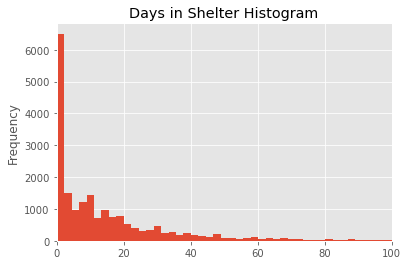

In [18]:
df['Days in Shelter'].plot(kind='hist', bins=400, xlim=(0,100), title='Days in Shelter Histogram')
df['Days in Shelter'].describe()

In [19]:
df[df['Days in Shelter'] == 891]

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Intake_Month,Intake_dayofweek,Intake_Year,Outcome_Month,Outcome_dayofweek,Outcome_Year
364,PEARL,DOG,DACHSHUND,BROWN/WHITE,Spayed,SMALL,2009-12-18,K17-026012,DA47,A308868,2017-10-24,2020-04-02,891,CONFISCATE,FLD_CRUEL,TRANSFER,ROCKET DOG,TREATABLE/MANAGEABLE,TREATABLE/MANAGEABLE,COUNTY,OUT OF COUNTY,94146.0,"94146(37.78008, -122.420168)",1,10,1,2017,4.0,3.0,2020.0
369,ZIGZAG,DOG,DACHSHUND,BROWN/WHITE,Neutered,SMALL,2008-10-24,K17-026010,DA46,A308867,2017-10-24,2020-04-02,891,CONFISCATE,FLD_CRUEL,TRANSFER,ROCKET DOG,TREATABLE/MANAGEABLE,TREATABLE/MANAGEABLE,COUNTY,OUT OF COUNTY,94146.0,"94146(37.78008, -122.420168)",1,10,1,2017,4.0,3.0,2020.0


Intake Condition
HEALTHY                 10923
TREATABLE/MANAGEABLE     1229
TREATABLE/REHAB          2054
UNKNOWN                  3838
UNTREATABLE              1925
Name: Animal ID, dtype: int64

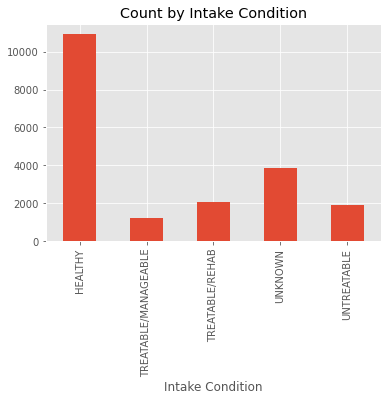

In [20]:
df.groupby('Intake Condition').count()['Animal ID'].plot(kind='bar', title="Count by Intake Condition")
df.groupby('Intake Condition').count()['Animal ID']
#about 19% of the animal intake --> unknown intake condition
    #how to take care of these NaNs...?

Outcome Condition
DEAD                      309
HEALTHY                 12956
PENDING                  1543
TREATABLE/MANAGEABLE     1248
TREATABLE/REHAB          1217
UNTREATABLE              2383
Name: Animal ID, dtype: int64

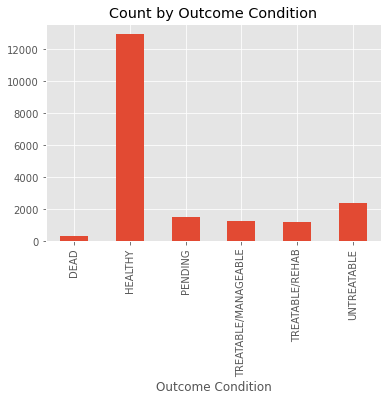

In [21]:
df.groupby('Outcome Condition').count()['Animal ID'].plot(kind='bar', title='Count by Outcome Condition')
df.groupby('Outcome Condition').count()['Animal ID']

Type
CAT       7120
DOG      11285
OTHER     1564
Name: Sex, dtype: int64

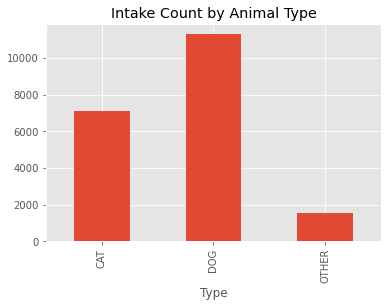

In [23]:
df.groupby('Type').count()['Sex'].plot(kind='bar', title='Intake Count by Animal Type')
df.groupby('Type').count()['Sex']
#1556 rows, or 8%, of the data is type "Other".. includes donkey, pig, rabbit, goat, etc.

### How to take care of NaN values?
- What about "unknown" string values? (e.g. intake condition)
- Name NaN's shouldn't matter.
- Date of birth -- how to replace NaNs?
    - Create an "age" column: outcome date - date of birth

## Drop columns that are irrelevant and/or `Outcome` related
- Outcome columns will lead to data leakage as they're explanatory columns
- Simplify 'Sex' column into Male, Female, Unknown (currently we have Spayed and Neutered as well)

In [25]:
#We have a new dependent variable -- 'Days in Shelter'

def drop_cols(df):
    
    drop_cols = ['Name', 'Impound Number', 'Kennel Number', 'Outcome Subtype', 
                 'Intake Jurisdiction', 'Outcome Jurisdiction', 'Outcome Jurisdiction', 
                 'Location', 'Count', 'Animal ID', 'Outcome Type'
                 'Intake Type', 'Intake Subtype', 'Outcome Condition', 
                 'Outcome Date', 'Outcome Zip Code', 'Outcome_Month', 'Outcome_dayofweek',
                'Outcome_Year']
    
    df = df.drop(columns=drop_cols)
    
    return df

df = drop_cols(df)

In [30]:
# A lot of different breeds -- how to handle?

len(df.groupby('Type')['Breed'].unique()['CAT'])
#49 cat breeds

len(df.groupby('Type')['Breed'].unique()['DOG'])
#774 dog breeds

len(df.groupby('Type')['Breed'].unique()['OTHER'])
#120 'other' breeds


# Separate mixed breeds into 2 separate breed columns
def separate_breed(df):
    df['Breed'] = df['Breed'].str.replace('/MIX', '')
    new_val = df['Breed'].str.split('/', n=1, expand=True)
    
    df['Breed_1'] = new_val[0]
    df['Breed_2'] = new_val[1]
    
    df = df.drop(columns='Breed', inplace=True)
    
    return df

separate_breed(df)

<ipython-input-30-6ffda69caef2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Breed'] = df['Breed'].str.replace('/MIX', '')
<ipython-input-30-6ffda69caef2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Breed_1'] = new_val[0]
<ipython-input-30-6ffda69caef2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [31]:
def separate_color(df):
    new_val = df['Color'].str.split('/', n=1, expand=True)
    
    df['Color_1'] = new_val[0]
    df['Color_2'] = new_val[1]
    
    df = df.drop(columns='Color', inplace=True)
    
    return df

separate_color(df)

<ipython-input-31-b7466e46b495>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Color_1'] = new_val[0]
<ipython-input-31-b7466e46b495>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Color_2'] = new_val[1]


In [32]:
# Treatable/Rehab and Treatable/Manageable into a single value -- Treatable

def simplify_intake_condition(df):
    new_val = df['Intake Condition'].str.split('/', n=1, expand=True)
    df['Intake Condition'] = new_val[0]
    
    return df

simplify_intake_condition(df)

<ipython-input-32-23cfec3cc006>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Intake Condition'] = new_val[0]


,Type,Sex,Size,Intake Date,Outcome Type,Intake Condition,Intake_Month,Intake_dayofweek,Intake_Year,Age,Breed_1,Breed_2,Color_1,Color_2
0,DOG,Female,MED,2020-01-19,1,HEALTHY,1,6,2020,1.96,GERM SHEPHERD,None,BLACK,TAN
1,DOG,Male,SMALL,2017-08-30,1,UNKNOWN,8,2,2017,2.40,BEAGLE,None,TRICOLOR,None
2,DOG,Female,LARGE,2015-01-07,1,HEALTHY,1,2,2015,3.96,LABRADOR RETR,None,BLACK,None
3,DOG,Unknown,MED,2020-07-12,1,UNKNOWN,7,6,2020,1.96,GERM SHEPHERD,None,TRICOLOR,None
4,CAT,Male,SMALL,2018-07-12,1,HEALTHY,7,3,2018,0.17,DOMESTIC SH,None,BLACK,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,CAT,Male,SMALL,2016-02-13,1,HEALTHY,2,5,2016,4.98,DOMESTIC SH,None,BLACK,None
19965,DOG,Female,SMALL,2015-03-14,0,TREATABLE,3,5,2015,1.96,CHIHUAHUA SH,None,TAN,None
19966,DOG,Male,SMALL,2018-06-15,1,UNKNOWN,6,4,2018,7.01,BICHON FRISE,None,CREAM,None
19967,CAT,Female,SMALL,2017-10-09,1,UNKNOWN,10,0,2017,7.99,DOMESTIC SH,None,BLACK,WHITE


In [33]:
df['Intake Condition'].unique()

array(['HEALTHY', 'UNKNOWN', 'TREATABLE', 'UNTREATABLE'], dtype=object)

In [34]:
df.isna().sum()

Type                    0
Sex                     0
Size                   31
Intake Date             0
Outcome Type            0
Intake Condition        0
Intake_Month            0
Intake_dayofweek        0
Intake_Year             0
Age                     0
Breed_1                 0
Breed_2             18458
Color_1                 0
Color_2              9921
dtype: int64

In [35]:
# Take care of NaN's before creating dummies

df['Size'].fillna('Unknown', inplace=True)
# df['Breed_2'].fillna('None', inplace=True)
# df['Color_2'].fillna('None', inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


# WHY IS THIS NOT WORKING

In [36]:
#get dummies for - Sex, Type, Size, Breed_1, Breed_2, Color_1, Color_2, Intake_Condition
need_dummies = ['Type', 'Sex', 'Size', 'Intake Condition', 
                'Breed_1', 'Breed_2', 'Color_1', 'Color_2']

def dummify_categ_cols(df):
    
    for col in need_dummies:
        
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
        
        
        df = df.drop(columns=col)
    
    return df

dummy_df = dummify_categ_cols(df)

In [37]:
dummy_df

,Intake Date,Outcome Type,Intake_Month,Intake_dayofweek,Intake_Year,Age,Type_CAT,Type_DOG,Type_OTHER,Sex_Female,Sex_Male,Sex_Unknown,Size_LARGE,Size_MED,Size_SMALL,Size_Unknown,Size_X-LRG,Intake Condition_HEALTHY,Intake Condition_TREATABLE,Intake Condition_UNKNOWN,Intake Condition_UNTREATABLE,Breed_1_ABYSSINIAN,Breed_1_AFFENPINSCHER,Breed_1_AIREDALE TERR,Breed_1_AKBASH,Breed_1_AKITA,Breed_1_ALASK MALAMUTE,Breed_1_ALASKAN HUSKY,Breed_1_ALPINE,Breed_1_AM PIT BULL TER,Breed_1_AMER BULLDOG,Breed_1_AMER ESKIMO,Breed_1_AMER FOXHOUND,Breed_1_AMER SH,Breed_1_AMERICAN,Breed_1_AMERICAN SABLE,Breed_1_AMERICAN STAFF,Breed_1_ANATOL SHEPHERD,Breed_1_ANGORA-ENGLISH,Breed_1_ANGORA-FRENCH,Breed_1_ANGORA-SATIN,Breed_1_ANGUS,Breed_1_APPALOOSA,Breed_1_ARABIAN,Breed_1_AUST CATTLE DOG,Breed_1_AUST KELPIE,Breed_1_AUST SHEPHERD,Breed_1_AUST TERRIER,Breed_1_BALINESE,Breed_1_BANTAM,Breed_1_BARRED ROCK,Breed_1_BASENJI,Breed_1_BASSET HOUND,Breed_1_BAT,Breed_1_BEAGLE,Breed_1_BEARDED COLLIE,Breed_1_BELG MALINOIS,Breed_1_BELG TERVUREN,Breed_1_BENGAL,Breed_1_BERNESE MTN DOG,Breed_1_BICHON FRISE,Breed_1_BLACK,Breed_1_BLACK MOUTH CUR,Breed_1_BLOODHOUND,Breed_1_BLUETICK HOUND,Breed_1_BOER,Breed_1_BOERBOEL,Breed_1_BORDER COLLIE,Breed_1_BORDER COLLIE X,Breed_1_BORDER TERRIER,Breed_1_BOSTON TERRIER,Breed_1_BOUV FLANDRES,Breed_1_BOXER,Breed_1_BRITISH SH,Breed_1_BRITTANY,Breed_1_BRUSS GRIFFON,Breed_1_BULL TERRIER,Breed_1_BULLDOG,Breed_1_BULLMASTIFF,Breed_1_BURMESE,Breed_1_CAIRN TERRIER,Breed_1_CALIFORNIAN,Breed_1_CANARY,Breed_1_CANE CORSO,Breed_1_CAROLINA DOG,Breed_1_CATAHOULA,Breed_1_CAVALIER SPAN,Breed_1_CHAMPGN DARGENT,Breed_1_CHESA BAY RETR,Breed_1_CHICKEN,Breed_1_CHIHUAHUA & MIN,Breed_1_CHIHUAHUA & MIX,Breed_1_CHIHUAHUA LH,Breed_1_CHIHUAHUA SH,Breed_1_CHIHUAHUA X,Breed_1_CHINCHILLA,Breed_1_CHINESE CRESTED,Breed_1_CHINESE SHARPEI,Breed_1_CHOW CHOW,Breed_1_CLUMBER SPAN,Breed_1_COCKATIEL,Breed_1_COCKATOO,Breed_1_COCKER SPAN,Breed_1_COLD WATER,Breed_1_COLLIE ROUGH,Breed_1_COLLIE SMOOTH,Breed_1_CONURE,Breed_1_CORNISH REX,Breed_1_COTON DE TULEAR,Breed_1_DACHSHUND,Breed_1_DACHSHUND LH,Breed_1_DACHSHUND WH,Breed_1_DALMATIAN,Breed_1_DEGU,Breed_1_DOBERMAN PINSCH,Breed_1_DOGO ARGENTINO,Breed_1_DOGUE DE BORDX,Breed_1_DOMESTIC LH,Breed_1_DOMESTIC MH,Breed_1_DOMESTIC SH,Breed_1_DONKEY,Breed_1_DOVE,Breed_1_DUCK,Breed_1_DUTCH,Breed_1_DUTCH SHEPHERD,Breed_1_DWARF HOTOT,Breed_1_EGYPTIAN MAU,Breed_1_ENG BULLDOG,Breed_1_ENG COONHOUND,Breed_1_ENG FOXHOUND,Breed_1_ENG POINTER,Breed_1_ENG SETTER,Breed_1_ENG SPRNGR SPAN,Breed_1_ENG TOY SPANIEL,Breed_1_ENGLISH SPOT,Breed_1_EXOTIC SH,Breed_1_FERRET,Breed_1_FINCH,Breed_1_FLAT COAT RETR,Breed_1_FLEMISH GIANT,Breed_1_FOX,Breed_1_FOX TERR SMOOTH,Breed_1_FOX TERR WIRE,Breed_1_FRENCH BULLDOG,Breed_1_GERM SH POINT,Breed_1_GERM SHEPHERD,Breed_1_GERM WH POINT,Breed_1_GOAT,Breed_1_GOLDEN RETR,Breed_1_GOOSE,Breed_1_GR SWISS MTN,Breed_1_GREAT DANE,Breed_1_GREAT PYRENEES,Breed_1_GREYHOUND,Breed_1_GUINEA PIG,Breed_1_HAMSTER,Breed_1_HARLEQUIN,Breed_1_HARRIER,Breed_1_HAVANA,Breed_1_HAVANESE,Breed_1_HERON,Breed_1_HIMALAYAN,Breed_1_HORSE,Breed_1_HOTOT,Breed_1_HOUND,Breed_1_IBIZAN HOUND,Breed_1_IRISH SETTER,Breed_1_IRISH TERRIER,Breed_1_IRISH WOLFHOUND,Breed_1_ITAL GREYHOUND,Breed_1_JACK,Breed_1_JAPANESE CHIN,Breed_1_JERSEY,Breed_1_JINDO,Breed_1_KOI,Breed_1_KOMONDOR,Breed_1_LA MANCHA,Breed_1_LABRADOR & GOLD,Breed_1_LABRADOR RETR,Breed_1_LEGHORN,Breed_1_LEONBERGER,Breed_1_LHASA APSO,Breed_1_LILAC,Breed_1_LLAMA,Breed_1_LOP-AMER FUZZY,Breed_1_LOP-ENGLISH,Breed_1_LOP-FRENCH,Breed_1_LOP-HOLLAND,Breed_1_LOP-MINI,Breed_1_LOVEBIRD,Breed_1_MACAW,Breed_1_MAINE COON,Breed_1_MALTESE,Breed_1_MANCHESTER TERR,Breed_1_MANX,Breed_1_MAREMMA SHEEPDG,Breed_1_MASTIFF,Breed_1_MIN PINSCHER,Breed_1_MIX,Breed_1_MOUSE,Breed_1_MULE,Breed_1_MUNCHKIN SH,Breed_1_MUSCOVY,Breed_1_NETHERLND DWARF,Breed_1_NEW ZEALAND WHT,Breed_1_NEWFOUNDLAND,Breed_1_NORFOLK TERRIER,Breed_1_NORW BUHUND,Breed_1_NORW ELKHOUND,Breed_1_NORWICH TERRIER,Breed_1_OCICAT,Breed_1_OLD ENG BULLDOG,Breed_1_OPOSSUM,Bree

In [38]:
df

,Type,Sex,Size,Intake Date,Outcome Type,Intake Condition,Intake_Month,Intake_dayofweek,Intake_Year,Age,Breed_1,Breed_2,Color_1,Color_2
0,DOG,Female,MED,2020-01-19,1,HEALTHY,1,6,2020,1.96,GERM SHEPHERD,None,BLACK,TAN
1,DOG,Male,SMALL,2017-08-30,1,UNKNOWN,8,2,2017,2.40,BEAGLE,None,TRICOLOR,None
2,DOG,Female,LARGE,2015-01-07,1,HEALTHY,1,2,2015,3.96,LABRADOR RETR,None,BLACK,None
3,DOG,Unknown,MED,2020-07-12,1,UNKNOWN,7,6,2020,1.96,GERM SHEPHERD,None,TRICOLOR,None
4,CAT,Male,SMALL,2018-07-12,1,HEALTHY,7,3,2018,0.17,DOMESTIC SH,None,BLACK,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,CAT,Male,SMALL,2016-02-13,1,HEALTHY,2,5,2016,4.98,DOMESTIC SH,None,BLACK,None
19965,DOG,Female,SMALL,2015-03-14,0,TREATABLE,3,5,2015,1.96,CHIHUAHUA SH,None,TAN,None
19966,DOG,Male,SMALL,2018-06-15,1,UNKNOWN,6,4,2018,7.01,BICHON FRISE,None,CREAM,None
19967,CAT,Female,SMALL,2017-10-09,1,UNKNOWN,10,0,2017,7.99,DOMESTIC SH,None,BLACK,WHITE


In [39]:
df.groupby('Outcome Type').count()

,Type,Sex,Size,Intake Date,Intake Condition,Intake_Month,Intake_dayofweek,Intake_Year,Age,Breed_1,Breed_2,Color_1,Color_2
Outcome Type,,,,,,,,,,,,,
0,3056,3056,3056,3056,3056,3056,3056,3056,3056,3056,127,3056,1490
1,16820,16820,16820,16820,16820,16820,16820,16820,16820,16820,1291,16820,8465


In [40]:
df['Outcome Type'].unique()

array([1, 0])

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19876 entries, 0 to 19968
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Type              19876 non-null  object        
 1   Sex               19876 non-null  object        
 2   Size              19876 non-null  object        
 3   Intake Date       19876 non-null  datetime64[ns]
 4   Outcome Type      19876 non-null  int64         
 5   Intake Condition  19876 non-null  object        
 6   Intake_Month      19876 non-null  int64         
 7   Intake_dayofweek  19876 non-null  int64         
 8   Intake_Year       19876 non-null  int64         
 9   Age               19876 non-null  float64       
 10  Breed_1           19876 non-null  object        
 11  Breed_2           1418 non-null   object        
 12  Color_1           19876 non-null  object        
 13  Color_2           9955 non-null   object        
dtypes: datetime64[ns](1), 

In [42]:
# Clean up NaN Values -
    # Size - < 1%
    # Outcome Type < 1%
    # Breed_2 - 93% -- replace with 'n/a'
    # Color_2 - 50% -- replace with 'n/a'

In [43]:
dummy_df

,Intake Date,Outcome Type,Intake_Month,Intake_dayofweek,Intake_Year,Age,Type_CAT,Type_DOG,Type_OTHER,Sex_Female,Sex_Male,Sex_Unknown,Size_LARGE,Size_MED,Size_SMALL,Size_Unknown,Size_X-LRG,Intake Condition_HEALTHY,Intake Condition_TREATABLE,Intake Condition_UNKNOWN,Intake Condition_UNTREATABLE,Breed_1_ABYSSINIAN,Breed_1_AFFENPINSCHER,Breed_1_AIREDALE TERR,Breed_1_AKBASH,Breed_1_AKITA,Breed_1_ALASK MALAMUTE,Breed_1_ALASKAN HUSKY,Breed_1_ALPINE,Breed_1_AM PIT BULL TER,Breed_1_AMER BULLDOG,Breed_1_AMER ESKIMO,Breed_1_AMER FOXHOUND,Breed_1_AMER SH,Breed_1_AMERICAN,Breed_1_AMERICAN SABLE,Breed_1_AMERICAN STAFF,Breed_1_ANATOL SHEPHERD,Breed_1_ANGORA-ENGLISH,Breed_1_ANGORA-FRENCH,Breed_1_ANGORA-SATIN,Breed_1_ANGUS,Breed_1_APPALOOSA,Breed_1_ARABIAN,Breed_1_AUST CATTLE DOG,Breed_1_AUST KELPIE,Breed_1_AUST SHEPHERD,Breed_1_AUST TERRIER,Breed_1_BALINESE,Breed_1_BANTAM,Breed_1_BARRED ROCK,Breed_1_BASENJI,Breed_1_BASSET HOUND,Breed_1_BAT,Breed_1_BEAGLE,Breed_1_BEARDED COLLIE,Breed_1_BELG MALINOIS,Breed_1_BELG TERVUREN,Breed_1_BENGAL,Breed_1_BERNESE MTN DOG,Breed_1_BICHON FRISE,Breed_1_BLACK,Breed_1_BLACK MOUTH CUR,Breed_1_BLOODHOUND,Breed_1_BLUETICK HOUND,Breed_1_BOER,Breed_1_BOERBOEL,Breed_1_BORDER COLLIE,Breed_1_BORDER COLLIE X,Breed_1_BORDER TERRIER,Breed_1_BOSTON TERRIER,Breed_1_BOUV FLANDRES,Breed_1_BOXER,Breed_1_BRITISH SH,Breed_1_BRITTANY,Breed_1_BRUSS GRIFFON,Breed_1_BULL TERRIER,Breed_1_BULLDOG,Breed_1_BULLMASTIFF,Breed_1_BURMESE,Breed_1_CAIRN TERRIER,Breed_1_CALIFORNIAN,Breed_1_CANARY,Breed_1_CANE CORSO,Breed_1_CAROLINA DOG,Breed_1_CATAHOULA,Breed_1_CAVALIER SPAN,Breed_1_CHAMPGN DARGENT,Breed_1_CHESA BAY RETR,Breed_1_CHICKEN,Breed_1_CHIHUAHUA & MIN,Breed_1_CHIHUAHUA & MIX,Breed_1_CHIHUAHUA LH,Breed_1_CHIHUAHUA SH,Breed_1_CHIHUAHUA X,Breed_1_CHINCHILLA,Breed_1_CHINESE CRESTED,Breed_1_CHINESE SHARPEI,Breed_1_CHOW CHOW,Breed_1_CLUMBER SPAN,Breed_1_COCKATIEL,Breed_1_COCKATOO,Breed_1_COCKER SPAN,Breed_1_COLD WATER,Breed_1_COLLIE ROUGH,Breed_1_COLLIE SMOOTH,Breed_1_CONURE,Breed_1_CORNISH REX,Breed_1_COTON DE TULEAR,Breed_1_DACHSHUND,Breed_1_DACHSHUND LH,Breed_1_DACHSHUND WH,Breed_1_DALMATIAN,Breed_1_DEGU,Breed_1_DOBERMAN PINSCH,Breed_1_DOGO ARGENTINO,Breed_1_DOGUE DE BORDX,Breed_1_DOMESTIC LH,Breed_1_DOMESTIC MH,Breed_1_DOMESTIC SH,Breed_1_DONKEY,Breed_1_DOVE,Breed_1_DUCK,Breed_1_DUTCH,Breed_1_DUTCH SHEPHERD,Breed_1_DWARF HOTOT,Breed_1_EGYPTIAN MAU,Breed_1_ENG BULLDOG,Breed_1_ENG COONHOUND,Breed_1_ENG FOXHOUND,Breed_1_ENG POINTER,Breed_1_ENG SETTER,Breed_1_ENG SPRNGR SPAN,Breed_1_ENG TOY SPANIEL,Breed_1_ENGLISH SPOT,Breed_1_EXOTIC SH,Breed_1_FERRET,Breed_1_FINCH,Breed_1_FLAT COAT RETR,Breed_1_FLEMISH GIANT,Breed_1_FOX,Breed_1_FOX TERR SMOOTH,Breed_1_FOX TERR WIRE,Breed_1_FRENCH BULLDOG,Breed_1_GERM SH POINT,Breed_1_GERM SHEPHERD,Breed_1_GERM WH POINT,Breed_1_GOAT,Breed_1_GOLDEN RETR,Breed_1_GOOSE,Breed_1_GR SWISS MTN,Breed_1_GREAT DANE,Breed_1_GREAT PYRENEES,Breed_1_GREYHOUND,Breed_1_GUINEA PIG,Breed_1_HAMSTER,Breed_1_HARLEQUIN,Breed_1_HARRIER,Breed_1_HAVANA,Breed_1_HAVANESE,Breed_1_HERON,Breed_1_HIMALAYAN,Breed_1_HORSE,Breed_1_HOTOT,Breed_1_HOUND,Breed_1_IBIZAN HOUND,Breed_1_IRISH SETTER,Breed_1_IRISH TERRIER,Breed_1_IRISH WOLFHOUND,Breed_1_ITAL GREYHOUND,Breed_1_JACK,Breed_1_JAPANESE CHIN,Breed_1_JERSEY,Breed_1_JINDO,Breed_1_KOI,Breed_1_KOMONDOR,Breed_1_LA MANCHA,Breed_1_LABRADOR & GOLD,Breed_1_LABRADOR RETR,Breed_1_LEGHORN,Breed_1_LEONBERGER,Breed_1_LHASA APSO,Breed_1_LILAC,Breed_1_LLAMA,Breed_1_LOP-AMER FUZZY,Breed_1_LOP-ENGLISH,Breed_1_LOP-FRENCH,Breed_1_LOP-HOLLAND,Breed_1_LOP-MINI,Breed_1_LOVEBIRD,Breed_1_MACAW,Breed_1_MAINE COON,Breed_1_MALTESE,Breed_1_MANCHESTER TERR,Breed_1_MANX,Breed_1_MAREMMA SHEEPDG,Breed_1_MASTIFF,Breed_1_MIN PINSCHER,Breed_1_MIX,Breed_1_MOUSE,Breed_1_MULE,Breed_1_MUNCHKIN SH,Breed_1_MUSCOVY,Breed_1_NETHERLND DWARF,Breed_1_NEW ZEALAND WHT,Breed_1_NEWFOUNDLAND,Breed_1_NORFOLK TERRIER,Breed_1_NORW BUHUND,Breed_1_NORW ELKHOUND,Breed_1_NORWICH TERRIER,Breed_1_OCICAT,Breed_1_OLD ENG BULLDOG,Breed_1_OPOSSUM,Bree

In [44]:
# Set up train and test set:

y = dummy_df['Outcome Type']
X = dummy_df.drop(columns=['Outcome Type', 'Intake Date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=15)

In [45]:
def train_smote(X_train, y_train):
    sm = SMOTE(random_state=15)
    print('Original dataset shape %s' % Counter(y_train))
    
    X_train, y_train = sm.fit_sample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_train))

    return X_train, y_train

X_train, y_train = train_smote(X_train, y_train)

Original dataset shape Counter({1: 12615, 0: 2292})
Resampled dataset shape Counter({1: 12615, 0: 12615})


In [47]:
# Parameter Search

# model = RandomForestClassifier()

# parameters = {'max_depth' : [50, 100],
#              'n_estimators': [500, 1000, 1500],
#              'max_features': ['auto', 'log', 'sqrt']}

# scorer = make_scorer(accuracy_score)

# clf = GridSearchCV(estimator=model,
#                    param_grid=parameters,
#                    cv=3,
#                    scoring='recall_weighted',
#                   verbose = 4, n_jobs=-1)

# clf.fit(X_train,y_train)
# # print(f"log loss = {-clf.score(X_test, y_test)}")

# print(f"accuracy = {(clf.predict(X_test) == y_test).mean()}")
# print(clf.best_params_)
# print(clf.best_estimator_)



# RESULT ---------------------------------------
# {'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1000}
# Accuracy = 0.935

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:  5.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  7.0min finished


accuracy = 0.9356007244918495
{'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1000}
RandomForestClassifier(max_depth=100, n_estimators=1000)


accuracy = 0.9362044676997384
F1 score: 0.9344861016680841
Recall score: 0.9362044676997384
              precision    recall  f1-score   support

           0     0.8331    0.7317    0.7791       764
           1     0.9523    0.9734    0.9627      4205

    accuracy                         0.9362      4969
   macro avg     0.8927    0.8525    0.8709      4969
weighted avg     0.9340    0.9362    0.9345      4969

Accuracy per class: [0.83308495 0.9523034 ]


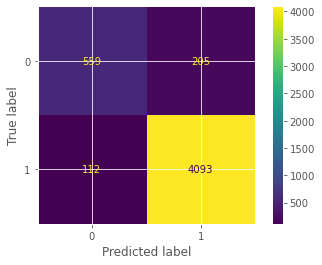

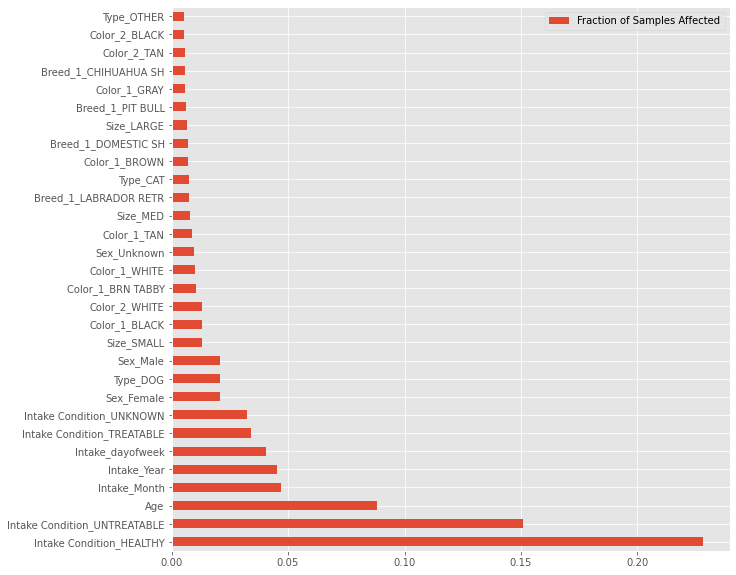

In [56]:
def run_rf_get_scores(X_train, X_test, y_train, y_test, n_estimators=1000, max_features='auto', max_depth=100):
    rf = RandomForestClassifier(n_estimators=n_estimators,
                               max_features=max_features,
                                max_depth=max_depth,
                               n_jobs=-1,
                               random_state=10)
    
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    
    # Accuracy
    print(f"accuracy = {rf.score(X_test, y_test)}")

    # f1 score
    print("F1 score:", f1_score(y_test, pred, average='weighted'))

    # recall score
    print("Recall score:", recall_score(y_test, pred, average='weighted'))
    
    # scores by class
    print(classification_report(y_test, pred, digits=4))
    
    # confusion matrix to calculate accuracy per class
    matrix = confusion_matrix(y_test, pred)
    acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

    print('Accuracy per class:', acc_per_class)
    
    # plot confusion matrix
    plot_confusion_matrix(rf, X_test, y_test)
    plt.show()
    
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
    feat_scores[:30].plot(kind='barh', figsize=(10,10))
    
run_rf_get_scores(X_train, X_test, y_train, y_test)

In [48]:
# AFTER classification, look into time series
time_series = df['Intake Date'].sort_values()